## Get The Embedding Function from Ollama

In [1]:
from langchain_community.embeddings.ollama import OllamaEmbeddings

def get_embedding_function():
    embeddings = OllamaEmbeddings(model="llama3")
    return embeddings

## Setting Up ChromaDB for Vector Database & Separate the Document into Chunks Partition

In [2]:
import argparse
import os
import sys
import shutil
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema.document import Document
from langchain.vectorstores.chroma import Chroma

In [6]:
import sys
import os
import shutil

CHROMA_PATH = "chroma"
DATA_PATH = "data"

def main(reset=False):  # Add reset as a function argument
    # Check if the database should be reset (manual argument)
    if reset:
        print("Clearing Database...")
        clear_database()

    # Continue processing documents
    documents = load_documents()
    chunks = split_documents(documents)
    add_to_chroma(chunks)

def load_documents():
    document_loader = PyPDFDirectoryLoader(DATA_PATH)
    return document_loader.load()

def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=700,
        chunk_overlap=30,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

def add_to_chroma(chunks: list[Document]):
    # Load the existing database.
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=get_embedding_function()
    )

    # Calculate Page IDs.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Add or Update the documents.
    existing_items = db.get(include=[])  # IDs are always included by default
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # Only add documents that don't exist in the DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"Adding new documents: {len(new_chunks)}...")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("No new documents to add")

def calculate_chunk_ids(chunks):
    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        chunk.metadata["id"] = chunk_id

    return chunks

def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

In [7]:
clear_database()

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'chroma\\chroma.sqlite3'

In [8]:
main(reset=False)

Number of existing documents in DB: 0
Adding new documents: 7...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_37000\2370614857.py:56: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


## Query Data for RAG

In [9]:
from langchain.vectorstores.chroma import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_community.llms.ollama import Ollama

CHROMA_PATH = "chroma"

PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

def query_rag(query_text: str):
    # Prepare the DB.
    embedding_function = get_embedding_function()
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Increase k to get more diverse results
    results = db.similarity_search_with_score(query_text, k=10)

    # Ensure results are unique and diverse
    unique_results = []
    seen_ids = set()
    for doc, score in results:
        chunk_id = doc.metadata.get("id", None)
        if chunk_id not in seen_ids:
            unique_results.append((doc, score))
            seen_ids.add(chunk_id)
    
    # Generate the context text from diverse chunks
    context_text = "\n\n---\n\n".join([doc.page_content for doc, _ in unique_results])

    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    print(prompt)

    model = Ollama(model="llama3")
    response_text = model.invoke(prompt)

    # Show source documents used
    sources = [doc.metadata.get("id", None) for doc, _ in unique_results]
    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text



## Testing the RAG Improved LLM

In [10]:
# Now you can call the query_rag function directly
query_text = "What is the functional requirements in the DAUR?"
query_rag(query_text)

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7


Human: 
Answer the question based only on the following context:

sampah  serta me lakukan real t ime tracking terhadap proses pengirimannya. 
Selanjutnya role sebagai kurir d apat menerima permintaan pengiriman sampah dari 
pelaku industri  dan telah disetujui oleh penerima / pengepul sampah . Dalam 
aplikasi ini, terdapat admin DAUR yang memiliki peran utama publikasi artikel 
edukasi . Selain admin, pengguna umum juga dapat melakukan publikasi artikel 
edukasi, tetapi membutuhkan veriﬁkasi dari admin untuk tiap artikel yang ingin 
dipublikasi.

---

Haﬁdh Husna | Rekayasa Perangkat Lunak  Indust ri / Pengirim Sampah, Pengepul / Penerima Sampah, Kurir, dan Pengguna 
Umum. Setiap role memiliki akses ﬁtur aplikasi yang berbeda, tetapi selu ruh role 
dapat mengakses artikel edukasi yang dipublikasikan oleh admin dan pengguna 
umum. Role sebagai pelaku industr i / pengirim sampah memiliki akses  di mana 
pengguna dapat melakukan permintaan pengiriman sampah dau r ulang serta dapat 
melak

'Based on the given context, the functional requirements of the DAUR are:\n\n1. Aplikasi memungkinkan pengguna untuk melakukan pendaftaran sebagai pelaku industri\n2. Permintaan mengirim sampah oleh pelaku industri\n3. Permintaan menerima sampah oleh pengepul/penerima sampah\n4. Tracking proses pengiriman sampah baik oleh pelaku industri maupun pengepul/penerima sampah\n5. Publikasi artikel edukasi yang dilakukan oleh admin aplikasi dan pengguna umum\n6. Verifikasi publikasi artikel edukasi oleh admin\n7. Membaca artikel edukasi yang dapat dilakukan oleh semua role\n8. Penerimaan pengiriman sampah oleh kurir\n\nThese are the functional requirements that define how the DAUR application should behave and what it should be able to do.'

## RAG Evaluation

In [11]:
EVAL_PROMPT = """
Expected Response: {expected_response}
Actual Response: {actual_response}
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 
"""

def query_and_validate(question: str, expected_response: str):
    response_text = query_rag(question)
    prompt = EVAL_PROMPT.format(
        expected_response=expected_response, actual_response=response_text
    )

    model = Ollama(model="llama3")
    evaluation_results_str = model.invoke(prompt)
    evaluation_results_str_cleaned = evaluation_results_str.strip().lower()

    print(prompt)

    if "true" in evaluation_results_str_cleaned:
        # Print response in Green if it is correct.
        print("\033[92m" + f"Response: {evaluation_results_str_cleaned}" + "\033[0m")
        return True
    elif "false" in evaluation_results_str_cleaned:
        # Print response in Red if it is incorrect.
        print("\033[91m" + f"Response: {evaluation_results_str_cleaned}" + "\033[0m")
        return False
    else:
        raise ValueError(
            f"Invalid evaluation result. Cannot determine if 'true' or 'false'."
        )

### Testing for Software Functional Requirements (Software Engineering Document)

In [12]:
def test_software_functional_requirements():
    assert query_and_validate(
        question="What is the functional requirements in the DAUR?",
        expected_response="""1. Aplikasi memungkinkan pengguna untuk melakukan pendaftaran sebagai pelaku 
industri  /  pengirim  sampah,  penerima  sampah,  kurir,  atau  sebagai  pengguna  
umum 2. Pelaku  industri  /  pengirim  sampah  dapat  melakukan  permintaan  pengiriman  
sampah 3. Penerima / pengepul sampah dapat menerima permintaan pengiriman sampah 
dari pelaku industri 
4. Kurir  dapat  menerima  permintaan  pengiriman  setelah  permintaan  pengiriman  
sudah disetujui oleh kedua belah pihak (pelaku industri dan pengepul sampah). 5. Pengguna umum dapat melakukan verifikasi publikasi artikel edukasi kepada 
admin 6. Admin dapat melakukan publikasi artikel edukasi 7. Admin dapat melakukan verifikasi permintaan publikasi artikel edukasi yang 
telah dibuat oleh pengguna umum 8. Aplikasi dapat menampilkan lokasi real-time ketika melakukan tracking proses 
pengiriman sampah""",
    )

In [13]:
test_software_functional_requirements()

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7


Human: 
Answer the question based only on the following context:

sampah  serta me lakukan real t ime tracking terhadap proses pengirimannya. 
Selanjutnya role sebagai kurir d apat menerima permintaan pengiriman sampah dari 
pelaku industri  dan telah disetujui oleh penerima / pengepul sampah . Dalam 
aplikasi ini, terdapat admin DAUR yang memiliki peran utama publikasi artikel 
edukasi . Selain admin, pengguna umum juga dapat melakukan publikasi artikel 
edukasi, tetapi membutuhkan veriﬁkasi dari admin untuk tiap artikel yang ingin 
dipublikasi.

---

Haﬁdh Husna | Rekayasa Perangkat Lunak  Indust ri / Pengirim Sampah, Pengepul / Penerima Sampah, Kurir, dan Pengguna 
Umum. Setiap role memiliki akses ﬁtur aplikasi yang berbeda, tetapi selu ruh role 
dapat mengakses artikel edukasi yang dipublikasikan oleh admin dan pengguna 
umum. Role sebagai pelaku industr i / pengirim sampah memiliki akses  di mana 
pengguna dapat melakukan permintaan pengiriman sampah dau r ulang serta dapat 
melak

## RAG Architecture Visualization

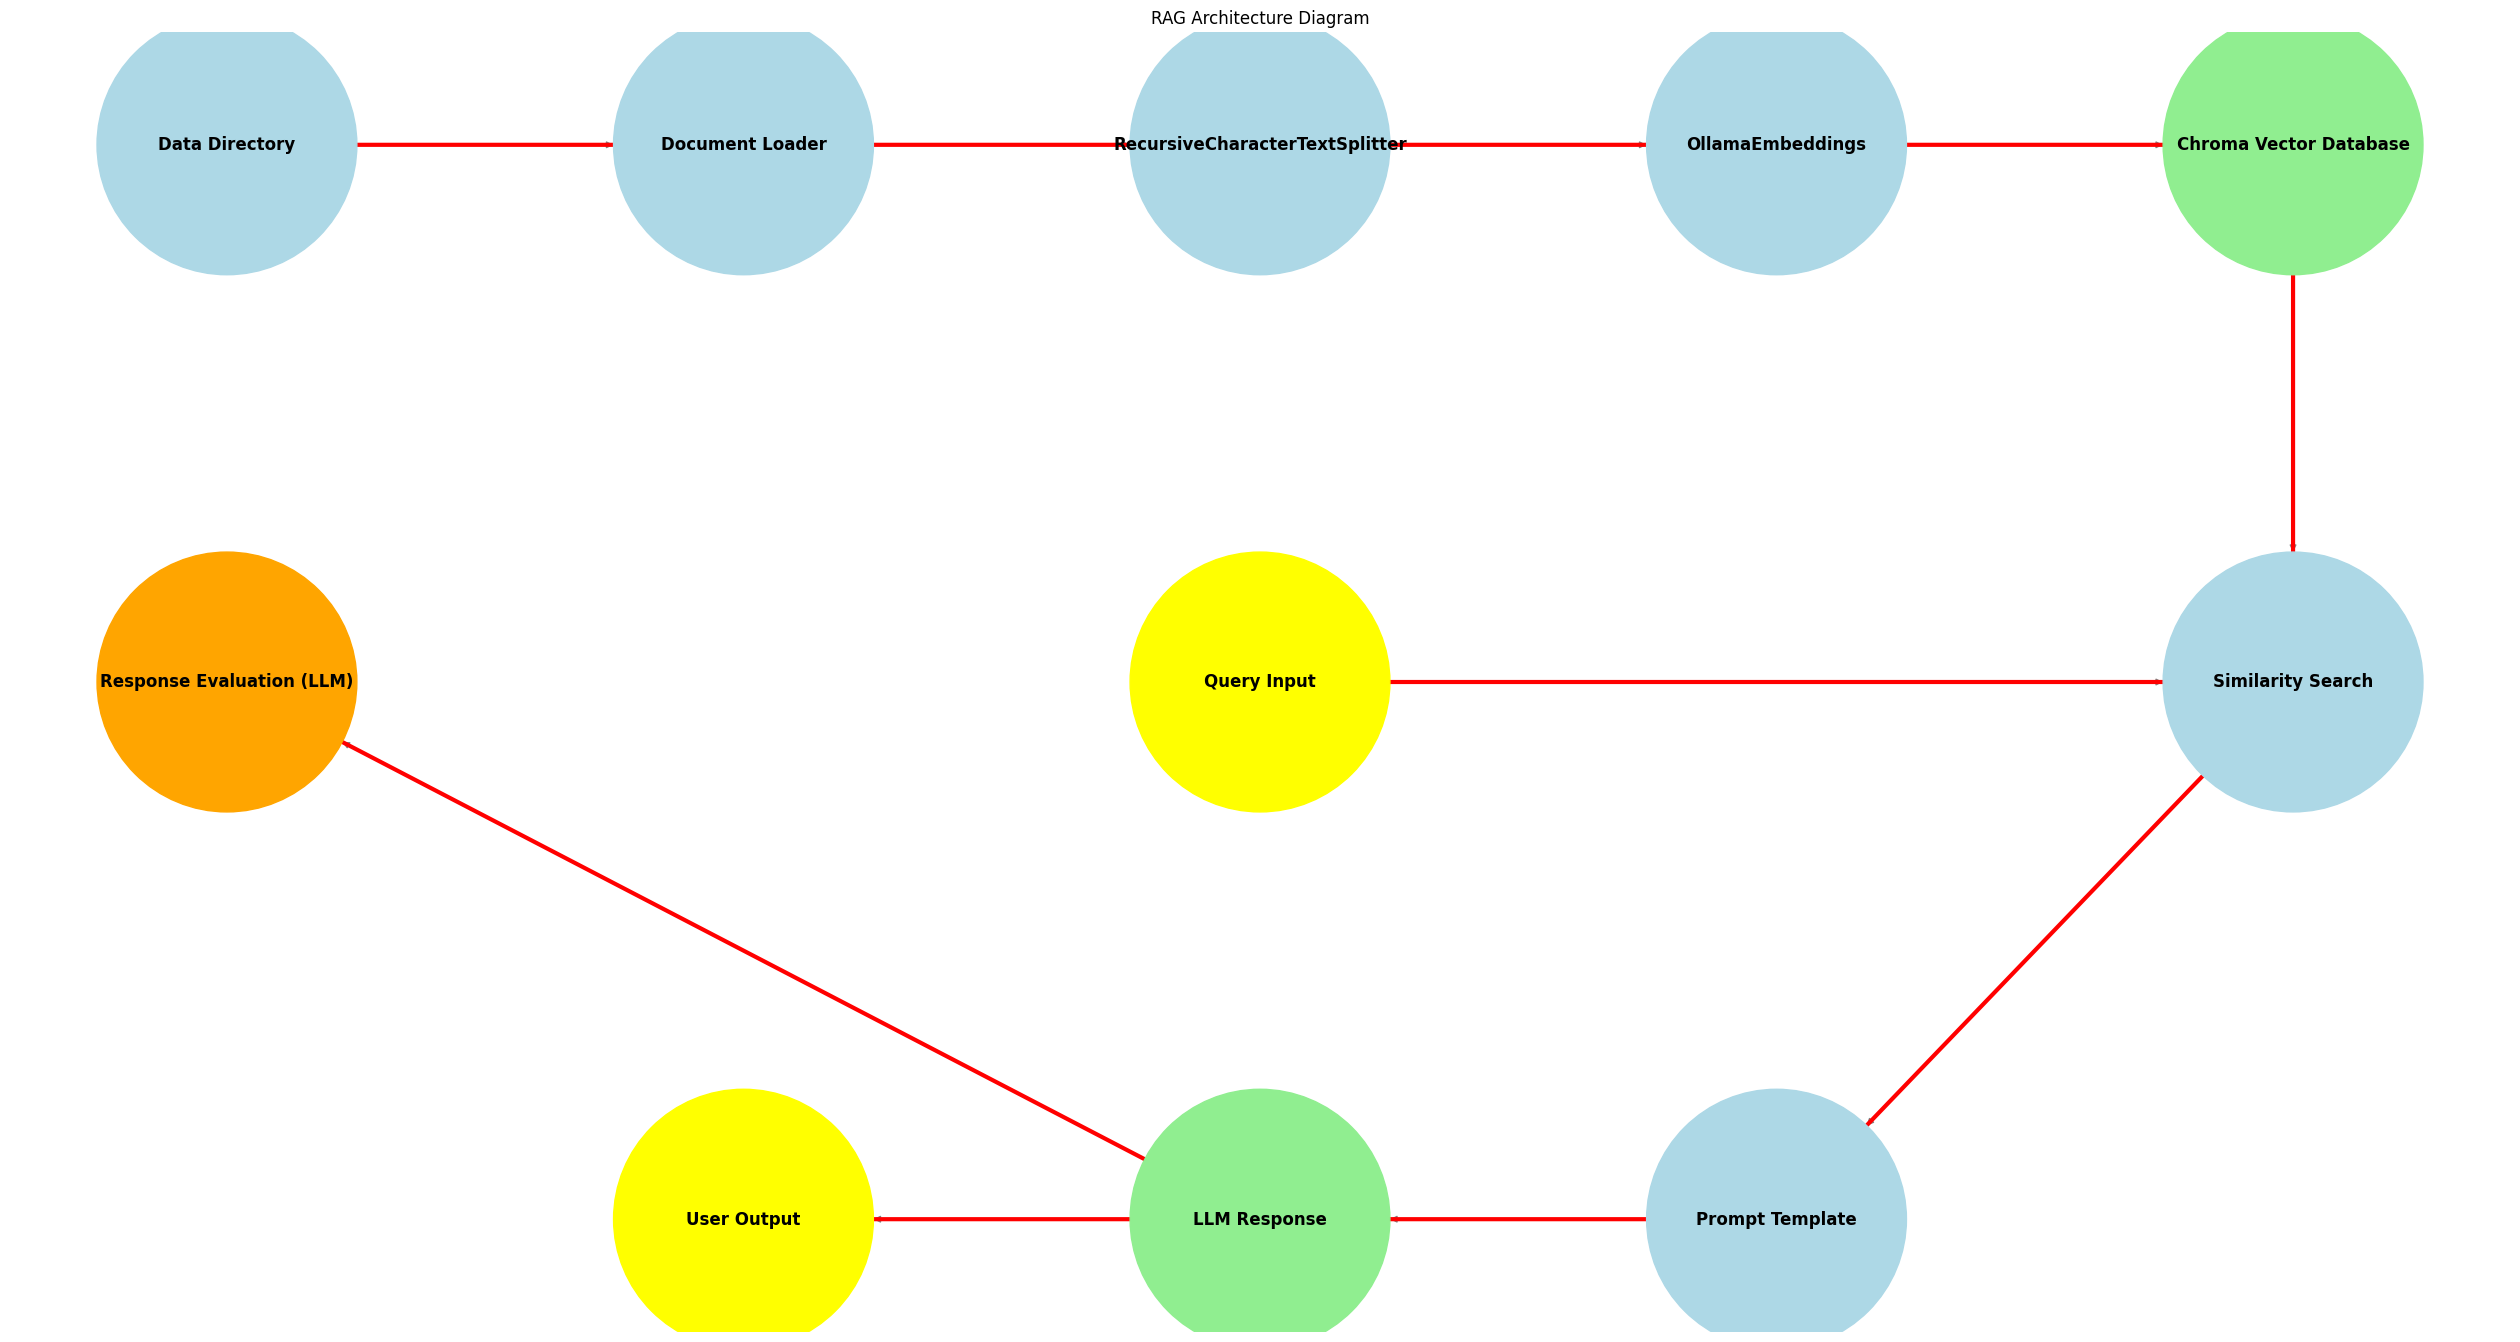

In [29]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each component of the architecture
G.add_node("Data Directory", pos=(0, 4), node_color='lightblue')
G.add_node("Document Loader", pos=(2, 4))
G.add_node("RecursiveCharacterTextSplitter", pos=(4, 4))
G.add_node("OllamaEmbeddings", pos=(6, 4))
G.add_node("Chroma Vector Database", pos=(8, 4), node_color='lightgreen')
G.add_node("Query Input", pos=(4, 2), node_color='yellow')
G.add_node("Similarity Search", pos=(8, 2))
G.add_node("Prompt Template", pos=(6, 0))
G.add_node("LLM Response", pos=(4, 0), node_color='lightgreen')
G.add_node("User Output", pos=(2, 0), node_color='yellow')

# Optional response evaluation
G.add_node("Response Evaluation (LLM)", pos=(0, 2), node_color='orange')

# Add edges to connect components
G.add_edges_from([
    ("Data Directory", "Document Loader"),
    ("Document Loader", "RecursiveCharacterTextSplitter"),
    ("RecursiveCharacterTextSplitter", "OllamaEmbeddings"),
    ("OllamaEmbeddings", "Chroma Vector Database"),
    ("Query Input", "Similarity Search"),
    ("Chroma Vector Database", "Similarity Search"),
    ("Similarity Search", "Prompt Template"),
    ("Prompt Template", "LLM Response"),
    ("LLM Response", "User Output"),
    ("LLM Response", "Response Evaluation (LLM)"),
])

# Get positions from the 'pos' attribute in the graph nodes
pos = nx.get_node_attributes(G, 'pos')

# Increase plot size
plt.figure(figsize=(25, 13))  # Adjust the figure size (width, height)

# Draw nodes with custom color, size, and labels
node_colors = ['lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'yellow', 
               'lightblue', 'lightblue', 'lightgreen', 'yellow', 'orange']
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=35000, 
        font_size=12, font_weight='bold', edge_color='gray')

# Draw edges with thicker arrows
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=30, edge_color='red', width=3)

# Show plot
plt.title("RAG Architecture Diagram")
plt.show()
